Device: cpu
Train / Test: 60000 10000
[Baseline-Recon] ep 1/4  L2(train)=0.0501
[Baseline-Recon] ep 2/4  L2(train)=0.0424
[Baseline-Recon] ep 3/4  L2(train)=0.0395
[Baseline-Recon] ep 4/4  L2(train)=0.0378
[Baseline-Recon] L2(test)=29.2568
[Baseline-Cls(clean)] ep 1/4  CE(train)=0.2327  Acc(train)=0.9292
[Baseline-Cls(clean)] ep 2/4  CE(train)=0.0571  Acc(train)=0.9826
[Baseline-Cls(clean)] ep 3/4  CE(train)=0.0399  Acc(train)=0.9875
[Baseline-Cls(clean)] ep 4/4  CE(train)=0.0287  Acc(train)=0.9909
[Baseline Label MSE] d–d̂ MSE(test)=0.034920


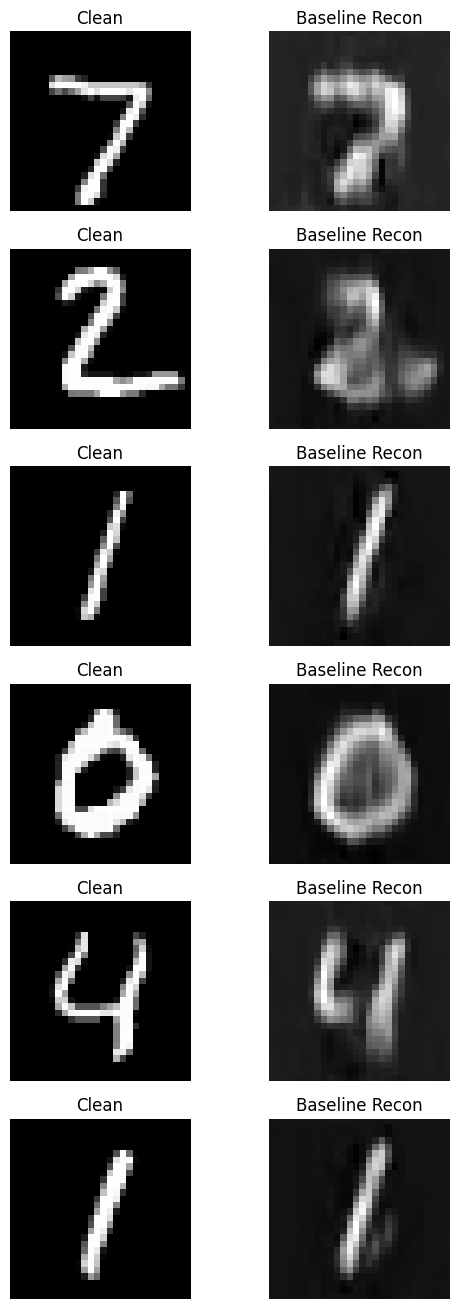

In [ ]:
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from skimage.transform import radon
import matplotlib.pyplot as plt

SEED = 123
torch.manual_seed(SEED); np.random.seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

ANGLES = 5
DETECTORS = 25
I0 = 60.0
ANGLES_DEG = np.linspace(0, 180, ANGLES, endpoint=False)

BATCH_SIZE = 128
NUM_WORKERS = 0
PIN_MEMORY = False
DATA_DIR = "./data"

# ---------- Forward model: radon -> Poisson counts ----------
def radon_counts_from_torch_images(x, I0=I0, angles_deg=ANGLES_DEG, out_detectors=DETECTORS):
    """
    x: torch float tensor [B,1,28,28] in [0,1]
    returns y: [B,1,ANGLES, out_detectors] (Poisson counts, integers)
    """
    device = x.device
    B = x.shape[0]
    sinos = []
    for i in range(B):
        img = x[i, 0].detach().cpu().numpy()
        sino = radon(img, theta=angles_deg, circle=False)      # [D_raw, A]
        sinos.append(sino[None, ...])                          # [1, D_raw, A]
    s = np.stack(sinos, axis=0)                                # [B, 1, D_raw, A]
    s_t = torch.from_numpy(s).to(device=device, dtype=torch.float32)  # torch
    # reorder to [B,1,A,D_raw], resample detector axis -> DETECTORS
    s_t = s_t.permute(0, 1, 3, 2)                              # [B,1,A,D_raw]
    s_t = F.interpolate(s_t, size=(s_t.shape[2], out_detectors),
                        mode="bilinear", align_corners=False)  # [B,1,A,D]
    with torch.no_grad():
        mu = (I0 * torch.exp(-s_t)).clamp_min(1e-8)
        y  = torch.poisson(mu)
    return y

def log_transform(y, I0=I0, eps=1.0):
    """ g = -log((y + eps)/I0), same shape as y """
    return -torch.log((y + eps) / I0)

# ---------- Dataset: returns (y, g, x, z) ----------
class TomoMNISTRadon(Dataset):
    def __init__(self, root, train=True):
        self.mnist = datasets.MNIST(root=root, train=train, download=True,
                                    transform=transforms.ToTensor())
    def __len__(self):
        return len(self.mnist)
    def __getitem__(self, idx):
        x, z = self.mnist[idx]                           # x:[1,28,28]
        y = radon_counts_from_torch_images(x.unsqueeze(0)).squeeze(0)  # [1,A,D]
        g = log_transform(y)                             # [1,A,D]
        return y, g, x, z

# ---------- Models ----------
class ReconNet(nn.Module):
    """ A†: [B,1,A,D] -> [B,1,28,28] (simple CNN upsampler) """
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 32, 3, padding=1)
        self.c2 = nn.Conv2d(32, 64, 3, padding=1)
        self.c3 = nn.Conv2d(64, 64, 3, padding=1)
        self.up = nn.Upsample(size=(28, 28), mode="bilinear", align_corners=False)
        self.c4 = nn.Conv2d(64, 32, 3, padding=1)
        self.out = nn.Conv2d(32, 1, 1)
    def forward(self, s):
        x = F.relu(self.c1(s))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = self.up(x)
        x = F.relu(self.c4(x))
        return self.out(x)

class Classifier(nn.Module):
    """ 28x28 -> 10 logits (3 conv + pooling + fc) """
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 32, 3, padding=1)
        self.c2 = nn.Conv2d(32, 64, 3, padding=1)
        self.c3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(128 * 3 * 3, 10) 
    def forward(self, x):
        x = self.pool(F.relu(self.c1(x)))
        x = self.pool(F.relu(self.c2(x)))
        x = self.pool(F.relu(self.c3(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)                    

# ---------- Loaders ----------
train_ds = TomoMNISTRadon(DATA_DIR, train=True)
test_ds  = TomoMNISTRadon(DATA_DIR, train=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print("Train / Test:", len(train_ds), len(test_ds))

# ---------- (1) Train reconstructor on (g -> x) with MSE ----------
recon = ReconNet().to(DEVICE)
opt_recon = torch.optim.Adam(recon.parameters(), lr=1e-3)
mse = nn.MSELoss()

EPOCHS_RECON_BASE = 4
for ep in range(EPOCHS_RECON_BASE):
    recon.train()
    run = 0.0
    for _, g, x, _ in train_loader:
        g, x = g.to(DEVICE), x.to(DEVICE)
        xhat = recon(g)
        loss = mse(xhat, x)
        opt_recon.zero_grad(); loss.backward(); opt_recon.step()
        run += loss.item() * x.size(0)
    print(f"[Baseline-Recon] ep {ep+1}/{EPOCHS_RECON_BASE}  L2(train)={run/len(train_ds):.4f}")

# test reconstruction MSE
recon.eval()
sum_sq = 0.0
with torch.no_grad():
    for _, g, x, _ in test_loader:
        g, x = g.to(DEVICE), x.to(DEVICE)
        xhat = recon(g)
        sum_sq += F.mse_loss(xhat, x, reduction="sum").item()
mse_recon_test = sum_sq / len(test_ds)
print(f"[Baseline-Recon] L2(test)={mse_recon_test:.4f}")

# ---------- (2) Train classifier on clean MNIST only ----------
mnist_train = datasets.MNIST(root=DATA_DIR, train=True,  download=True,
                             transform=transforms.ToTensor())
mnist_test  = datasets.MNIST(root=DATA_DIR, train=False, download=True,
                             transform=transforms.ToTensor())
mnist_train_ld = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True,
                            num_workers=0, pin_memory=False)
mnist_test_ld  = DataLoader(mnist_test,  batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=0, pin_memory=False)

clf = Classifier().to(DEVICE)
opt_clf = torch.optim.Adam(clf.parameters(), lr=1e-3)
ce = nn.CrossEntropyLoss()

EPOCHS_CLF_CLEAN = 4
for ep in range(EPOCHS_CLF_CLEAN):
    clf.train()
    run, correct, n = 0.0, 0, 0
    for x, z in mnist_train_ld:
        x, z = x.to(DEVICE), z.to(DEVICE)
        logits = clf(x)
        loss   = ce(logits, z)
        opt_clf.zero_grad(); loss.backward(); opt_clf.step()
        run += loss.item() * z.size(0)
        correct += (logits.argmax(1) == z).sum().item()
        n += z.numel()
    print(f"[Baseline-Cls(clean)] ep {ep+1}/{EPOCHS_CLF_CLEAN}  CE(train)={run/len(mnist_train):.4f}  Acc(train)={correct/n:.4f}")

# ----------Evaluate d–d^ MSE on reconstructions----------
# We pass reconstructed images x^ into the clean-trained classifier, get probs d^,
# build one-hot d from labels, and compute mean squared error per sample

def ddhat_mse_over_loader(recon, clf, loader, num_classes=10, device=DEVICE):
    recon.eval(); clf.eval()
    total_mse = 0.0
    total_N = 0
    with torch.no_grad():
        for _, g, _, z in loader:
            g, z = g.to(device), z.to(device)
            xhat = recon(g)                               # (B,1,28,28)
            logits = clf(xhat)                            # (B,10)
            probs  = torch.softmax(logits, dim=1)         # d̂
            onehot = F.one_hot(z, num_classes=num_classes).float()  # d
            # MSE per sample averaged over classes, then sum over batch
            mse_batch = F.mse_loss(probs, onehot, reduction='none').mean(dim=1)  # (B,)
            total_mse += mse_batch.sum().item()
            total_N   += z.size(0)
    return total_mse / total_N

dd_mse_test = ddhat_mse_over_loader(recon, clf, test_loader, num_classes=10, device=DEVICE)
print(f"[Baseline Label MSE] d–d̂ MSE(test)={dd_mse_test:.6f}")

# ---- quick visual of a few samples
def show_pairs(recon, loader, n=6):
    recon.eval()
    _, g, x, _ = next(iter(loader))
    g, x = g.to(DEVICE), x.to(DEVICE)
    with torch.no_grad():
        xhat = recon(g)
    x = x[:n].cpu().numpy(); xhat = xhat[:n].cpu().numpy()
    fig, ax = plt.subplots(n, 2, figsize=(6, 2.2*n))
    if n == 1: ax = np.array([ax])
    for i in range(n):
        ax[i,0].imshow(x[i,0], cmap='gray', vmin=0, vmax=1); ax[i,0].set_title('Clean'); ax[i,0].axis('off')
        ax[i,1].imshow(xhat[i,0], cmap='gray'); ax[i,1].set_title('Baseline Recon'); ax[i,1].axis('off')
    plt.tight_layout(); plt.show()

show_pairs(recon, test_loader, n=6)
